# Stock Market Analysis
The Random Walk Theory:
1. Changes in asset prices are random.
2. All factor already reflect in the latest price.
3. Past prices is not helpful in predicting the future prices accurately.
  
Hypothesis:  
There is a relationship between past stock prices and the next 30 days stock prices.

Evaluation Method:  
With the same past data as input there exist a Machine Learning model with an average "root mean squared error" of 30% lower than the Naive Forecast Model (Random Walk).

---
## Data Gathering
The S&P 500 index comprises the top 500 companies in the world's top economy. It is an great indication of the world's economic performance over time.
  
Data source: https://www.kaggle.com/datasets/gkitchen/s-and-p-500-spy

In [211]:
import os
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns

In [212]:
#Import data to dataframe
df = pd.read_csv(os.getcwd()+"/spy.csv", index_col = 'Date', parse_dates=True)
df.head()

,Open,High,Low,Close,Volume,Day,Weekday,Week,Month,Year
Date,,,,,,,,,,
1993-01-29,25.236158,25.236158,25.110605,25.218222,1003200,29,4,4,1,1993
1993-02-01,25.236146,25.397572,25.236146,25.397572,480500,1,0,5,2,1993
1993-02-02,25.379673,25.469354,25.325865,25.451418,201300,2,1,5,2,1993
1993-02-03,25.487270,25.738376,25.469334,25.720440,529400,3,2,5,2,1993
1993-02-04,25.810132,25.881876,25.523153,25.828068,531500,4,3,5,2,1993


In [213]:
#Extract selected columns and rows
df = df[['Open', 'High', 'Low', 'Close', 'Volume']][-365:]
df.head()

,Open,High,Low,Close,Volume
Date,,,,,
2021-09-16,437.237036,438.253573,434.011403,437.090424,77786700
2021-09-17,436.284401,436.725649,432.460073,432.832703,118425000
2021-09-20,426.439263,428.086648,420.536088,425.615570,166445500
2021-09-21,428.057238,429.410458,424.664403,425.213531,92526100
2021-09-22,427.586553,431.489315,425.331206,429.361420,102350100


In [214]:
#Save checkpoint
raw_df = df.copy()

---
## Exploratory Data Analysis
Desctiption:  
At this stage we are trying to identify the key characteristics of the data to determine is the data suitable to be used in building a forecasting model.

Data properties:  
- Time Series Data vs Cross Sectional Data

In [215]:
#load checkpoint
df = raw_df[['Close']].copy()

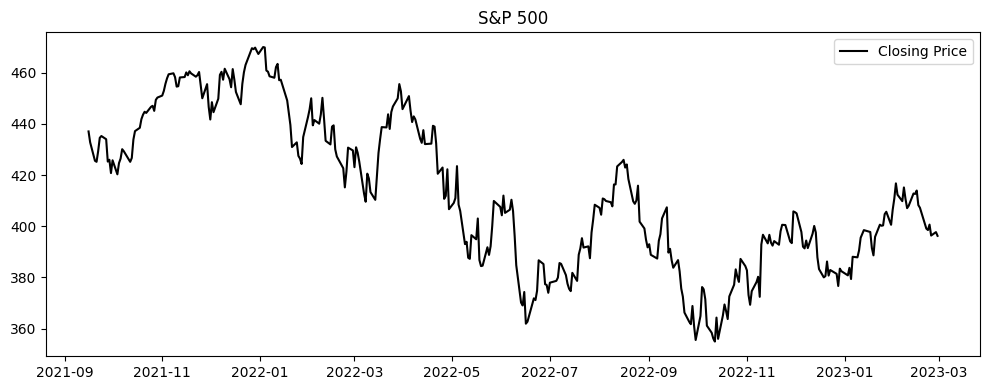

In [216]:
plt.figure(figsize=(10, 4))
plt.title("S&P 500")
plt.plot(df['Close'], label="Closing Price", color='black')
plt.legend()
plt.tight_layout()
plt.show()

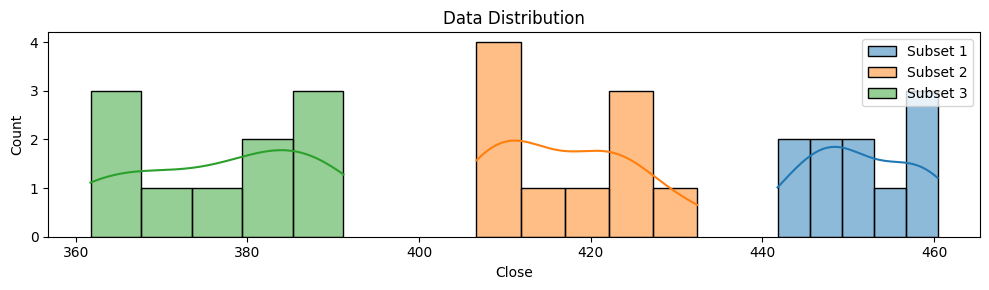

In [217]:
subset_df_1 = df['Close'][50:60]
subset_df_2 = df['Close'][150:160]
subset_df_3 = df['Close'][250:260]

plt.figure(figsize=(10, 3))
plt.title("Data Distribution")
sns.histplot(subset_df_1, kde=True, label="Subset 1")
sns.histplot(subset_df_2, kde=True, label="Subset 2")
sns.histplot(subset_df_3, kde=True, label="Subset 3")
plt.legend()
plt.tight_layout()
plt.show()

In [218]:
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df['Close'])
print("Augmented Dickey-Fuller Test")
print("p-value: {0}".format(adf_result[1]))
print("Conclusion: {0}".format("Non-Stationary" if adf_result[1]>=0.05 else "Stationary"))

Augmented Dickey-Fuller Test
p-value: 0.35566562792222156
Conclusion: Non-Stationary


Inference:  
From the graph it shows that the consistency in data distribution is low. From the dataset we see that there is a dependent relationship on each point of data. However, we want our feature to be independent so that we can find a pattern on how X impact the changes in y.

In [219]:
def cal_movavg(arr, window_size, i=0):
    if i<window_size:
        return np.append(np.nan, cal_movavg(arr, window_size, i+1))
    if i==len(arr)-1:
        return sum(arr[i-window_size:i])/window_size
    return np.append(sum(arr[i-window_size:i])/window_size, cal_movavg(arr, window_size, i+1))

In [220]:
#df['Moving_Average'] = df['Close'].ewm(com=10).mean()
df['Moving_Average'] = cal_movavg(df['Close'], 20)
df['Transformed_Close'] = df['Close']-df['Moving_Average']
df = df.dropna()
df.head()

,Close,Moving_Average,Transformed_Close
Date,,,
2021-10-14,433.911346,428.057332,5.854015
2021-10-15,437.215942,427.898378,9.317564
2021-10-18,438.510345,428.117540,10.392805
2021-10-19,441.893372,428.762279,13.131093
2021-10-20,443.629028,429.596271,14.032758


One common approach to make the data stationary is by differencing, meaning y(t)-y(t-1). But we decided to transform the data using close price to minux the rolling moving average.

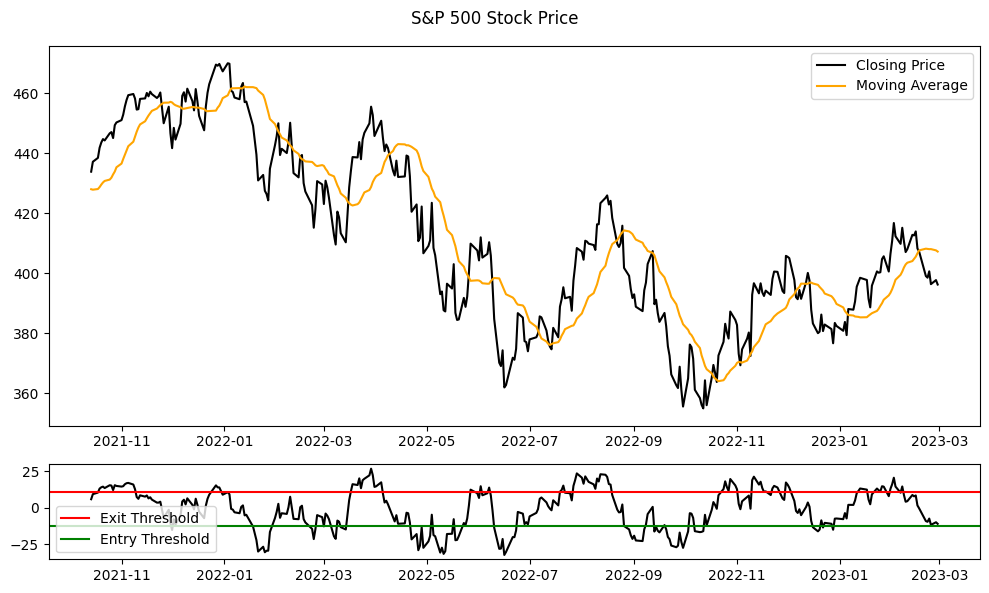

In [221]:
date_mask = (df.index)

display_df = df.loc[date_mask]
exit_threshold = display_df['Transformed_Close'].loc[(display_df['Transformed_Close']>0)].mean()
entry_threshold = display_df['Transformed_Close'].loc[(display_df['Transformed_Close']<0)].mean()

fig, ax = plt.subplots(2, 1, figsize=(10, 6), gridspec_kw={'height_ratios':[4, 1]})
fig.suptitle("S&P 500 Stock Price")
ax[0].plot(display_df['Close'], color='black', label="Closing Price")
ax[0].plot(display_df['Moving_Average'], color='orange', label="Moving Average")
ax[0].legend()
ax[1].plot(display_df['Transformed_Close'], color='black')
ax[1].axhline(exit_threshold, color='red', label="Exit Threshold")
ax[1].axhline(entry_threshold, color='green', label="Entry Threshold")
ax[1].legend()
fig.tight_layout()

In [222]:
from statsmodels.tsa.stattools import adfuller
adf_result = adfuller(df['Transformed_Close'])
print("Augmented Dickey-Fuller Test")
print("p-value: {0}".format(adf_result[1]))
print("Conclusion: {0}".format("Non-Stationary" if adf_result[1]>=0.05 else "Stationary"))

Augmented Dickey-Fuller Test
p-value: 0.0018938673242639766
Conclusion: Stationary


In [223]:
#Save checkpoint
transformed_df = df.copy()

---
## Sampling Data
Next, we have two sampling option to make the feature independent:  
  
Option 1: Static Windowed Method  
[t0] [t1] [t2] [t3] [t4] [t5] => [t6] [t7]  
[t1] [t2] [t3] [t4] [t5] [t6] => [t7] [t8]  
[t2] [t3] [t4] [t5] [t6] [t7] => [t8] [t9]   

Option 2: Rolling Windowed Method  
[t0] [t1] => [t2] [t3]  
[t0] [t1] [t2] => [t3] [t4]  
[t0] [t1] [t2] [t3] => [t4] [t5]  
  
We chose the static windowed method because price in stock market changes dramatically over time. It is irrelevent to take in past data that is far beyond.

In [224]:
#Load checkpoint
df = transformed_df.copy()

In [225]:
timestamp = df.index.to_numpy()
data = df['Transformed_Close'].to_numpy()
timestamp.shape, data.shape

((345,), (345,))

In [226]:
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler
from sklearn.preprocessing import MinMaxScaler
from sklearn.preprocessing import PowerTransformer
from sklearn.metrics import mean_squared_error
from sklearn.model_selection import train_test_split

class StaticData:
    
    def __init__(self, timestamp, data):
        #Set attributes
        self.timestamp = timestamp #Original timestamp
        self.data = data #Original data
        
        #Set states
        self.__fitted = False
        self.__transformed = False
        self.__split = False
        self.__preprocessed = False
        
    def fit(self, X_count, y_count):
        #Set attributes
        self.X_count = X_count #Number of feature
        self.y_count = y_count #Number of forecast step
        self.nset = self.data.shape[0]-(self.X_count+self.y_count)+1
        
        #Check sufficient data
        if self.nset<1:
            return False
        
        #Set uninitialized X y
        self.X_date = np.empty((self.nset, X_count), dtype='<M8[ns]') #X date
        self.y_date = np.empty((self.nset, y_count), dtype='<M8[ns]') #y date
        self.X = np.empty((self.nset, X_count), dtype=np.float32) #X
        self.y = np.empty((self.nset, y_count), dtype=np.float32) #y
        
        #Calculate sample weight
        self.sample_weight = np.array([])
        for i in range(self.y_count, 0, -1):
            self.sample_weight = np.append(self.sample_weight, i)
        self.sample_weight = self.sample_weight/self.sample_weight.sum()
        
        #Update state
        self.__fitted = True
        
        return self
        
    def transform(self, preprocess=False):
        
        #Check if fit() called
        if not self.__fitted:
            return False
        
        #Set X y value
        for i in range(0, self.nset, 1):
            break_X_y = i+self.X_count
            self.X_date[i] = self.timestamp[i:break_X_y]
            self.y_date[i] = self.timestamp[break_X_y:break_X_y+self.y_count]
            self.X[i] = self.data[i:break_X_y]
            self.y[i] = self.data[break_X_y:break_X_y+self.y_count]
            
        if preprocess:
            self.X_process = Pipeline([('Transformer', PowerTransformer())])
            self.y_process = Pipeline([('Transformer', PowerTransformer())])
            self.X = self.X_process.fit_transform(self.X)
            self.y = self.y_process.fit_transform(self.y)
            self.__preprocessed = True
        
        #Update state
        self.__transformed = True
        
        return self.X, self.y
    
    def split(self, train_size=0.7):
        #Check if transform() called
        if not self.__transformed:
            return False
        
        self.train_size = train_size
        self.X_train_date, self.X_val_date, self.y_train_date, self.y_val_date = train_test_split(self.X_date, self.y_date, train_size=self.train_size, shuffle=False)
        self.X_train, self.X_val, self.y_train, self.y_val = train_test_split(self.X, self.y, train_size=self.train_size, shuffle=False)
        
        #Update state
        self.__split = True
        
        return (self.X_train,
                self.X_val,
                self.y_train,
                self.y_val)
    
    def summary(self):
        print("===================================")
        print("Summary")
        print("===================================")
        print("Timestamp Shape: {0}".format(self.timestamp.shape))
        print("Data Shape: {0}".format(self.data.shape))
        if (self.__fitted):
            print("===================================")
            print("X y Combination")
            print("X Shape: {0}".format(self.X.shape))
            print("y Shape: {0}".format(self.y.shape))
            print("No. Set: {0}".format(self.nset))
        if (self.__preprocessed):
            print("===================================")
            print("Preprocessing")
            for i, layer in enumerate(self.X_process.get_params()['steps']):
                print("Layer {0}: {1}".format(i+1, layer[1]))
        if (self.__split):
            print("===================================")
            print("Train Val Set")
            print("X Train: {0}".format(self.X_train.shape))
            print("y Train: {0}".format(self.y_train.shape))
            print("X Val  : {0}".format(self.X_val.shape))
            print("y Val  : {0}".format(self.y_val.shape))
        print("===================================")
        
    def display(self, index=0):
        #Check if transform() called
        if not self.__transformed:
            return False
        
        #Invert preprocessed data for display only
        if self.__preprocessed:
            X = self.X_process.inverse_transform(self.X[index].reshape(1, -1)).flatten()
            y = self.y_process.inverse_transform(self.y[index].reshape(1, -1)).flatten()
        else:
            X = self.X[index]
            y = self.y[index]
        
        plt.figure(figsize=(10, 3))
        plt.title("Data Split\n{0}".format(np.datetime_as_string(self.X_date[index][-1], 'auto')))
        plt.plot(self.timestamp, self.data, color='black')
        plt.plot(self.X_date[index], X, color='green', label='Train')
        plt.plot(self.y_date[index], y, color='blue', label='True')
        plt.axvline(self.X_date[index][-1], color="black", linestyle='dashed')
        plt.legend()
        plt.tight_layout()
        plt.show()
    
    def display_forecast(self, index, pred):
        #Check if transform() called
        if not self.__transformed:
            return False
        
        #Invert preprocessed data for display only
        if self.__preprocessed:
            X = self.X_process.inverse_transform(self.X[index].reshape(1, -1)).flatten()
            y = self.y_process.inverse_transform(self.y[index].reshape(1, -1)).flatten()
            y_pred = self.y_process.inverse_transform(pred.reshape(1,-1)).flatten()
        else:
            X = self.X[index]
            y = self.y[index]
            y_pred = pred
        
        fig, ax = plt.subplots(2, 1, figsize=(10, 3), gridspec_kw={'height_ratios':[10, 1]})
        fig.suptitle("Forecast Result\n{0}".format(np.datetime_as_string(self.X_date[index][-1], 'auto')))
        ax[0].plot(self.timestamp, self.data, color='black')
        ax[0].plot(self.X_date[index], X, color='green', label="Train")
        ax[0].plot(self.y_date[index], y, color='blue', label="True")
        ax[0].plot(self.y_date[index], y_pred, color='darkorange', label="Pred")
        ax[0].axvline(self.X_date[index][-1], color="black", linestyle='dashed')
        ax[0].legend()
        ax[1].barh(['RMSE'],
                   round(mean_squared_error(self.y[index], pred, squared=False, sample_weight=self.sample_weight), 4),
                   color=['darkorange'])
        ax[1].set_xlim([0, 1])
        fig.tight_layout()

---
## Decide Sampling Rate with Simple LinearRegression Model
It adress the question of how many past data should be used to predict how many days ahead.

In [227]:
Xy = StaticData(timestamp, data)
Xy.fit(14, 14).transform(True)
X_train, X_val, y_train, y_val = Xy.split(.7)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((222, 14), (96, 14), (222, 14), (96, 14))

In [228]:
Xy.summary()

Summary
Timestamp Shape: (345,)
Data Shape: (345,)
X y Combination
X Shape: (318, 14)
y Shape: (318, 14)
No. Set: 318
Preprocessing
Layer 1: PowerTransformer()
Train Val Set
X Train: (222, 14)
y Train: (222, 14)
X Val  : (96, 14)
y Val  : (96, 14)


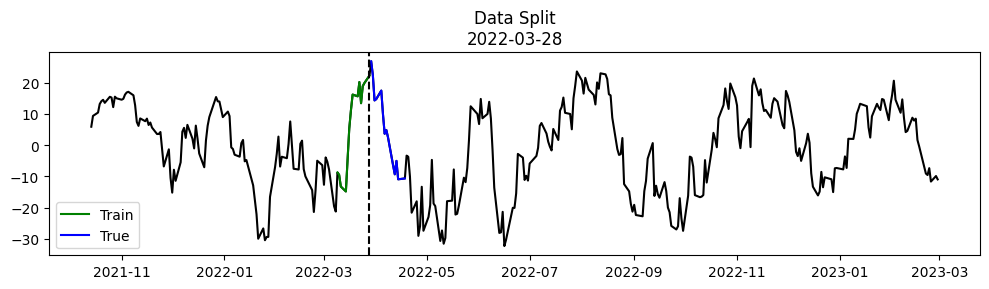

In [229]:
Xy.display(100)

In [230]:
import statsmodels.api as sm

In [231]:
#X_train_lm = sm.add_constant(X_train)
X_train_lm = X_train
y_train_lm = y_train

pvalues = np.empty((0, Xy.X_count), dtype=np.float32)
rsquared = np.empty((0, ), dtype=np.float32)

for i in range(0, Xy.y_count):
    model = sm.OLS(y_train_lm[:, i], X_train_lm).fit()
    pvalues = np.vstack((pvalues, model.pvalues))
    rsquared = np.hstack((rsquared, model.rsquared))

pvalues.shape, rsquared.shape

((14, 14), (14,))

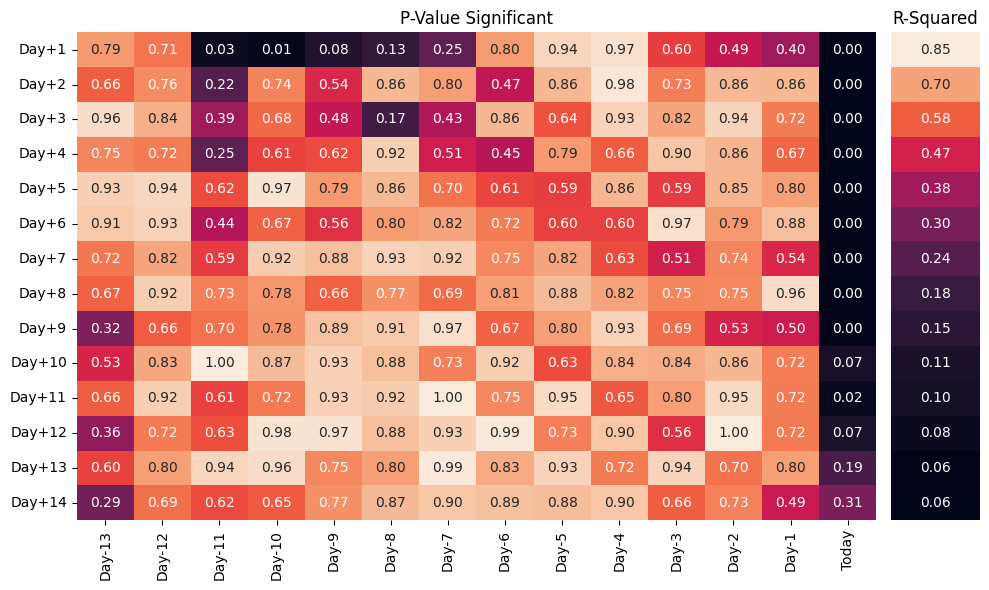

In [232]:
xticklabels = ["Day-{0}".format(i) for i in range(Xy.X_count-1, 0, -1)]+["Today"]
yticklabels = ["Day+{0}".format(i) for i in range(1, Xy.y_count+1, 1)]

fig, ax = plt.subplots(1, 2, figsize=(10, 6), gridspec_kw={'width_ratios':[9, 1]})
sns.heatmap(pvalues,
            xticklabels=xticklabels,
            yticklabels=yticklabels,
            ax=ax[0],
            annot=True,
            fmt=".2f",
            cbar=False)
ax[0].set_title("P-Value Significant")
sns.heatmap(rsquared.reshape(-1, 1),
            xticklabels=[],
            yticklabels=[],
            ax=ax[1],
            annot=True,
            fmt=".2f",
            cbar=False)
ax[1].set_title("R-Squared")
fig.tight_layout()

Inference:  
We can see that only the today's price is significant in predicting the future price. Moreover, it can only accurately predict up to a few day.

---
## Grid Search

In [233]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression

In [234]:
X_params = [5, 7, 12, 30, 60, 90, 120]
y_params = [30]

In [235]:
Xy = StaticData(timestamp, data)

rmse_train = np.zeros((len(X_params), len(y_params)), dtype=np.float32)
rmse_val = np.zeros((len(X_params), len(y_params)), dtype=np.float32)

for i, X_count in enumerate(X_params):
    for j, y_count in enumerate(y_params):
        Xy.fit(X_count, y_count).transform(True)
        X_train, X_val, y_train, y_val = Xy.split(.7)
        model = MultiOutputRegressor(LinearRegression()).fit(X_train, y_train)
        pred_train = model.predict(X_train)
        pred_val = model.predict(X_val)
        rmse_train[i, j] = np.mean([mean_squared_error(true, pred, squared=False, sample_weight=Xy.sample_weight) for true,pred in zip(y_train,pred_train)])
        rmse_val[i, j] = np.mean([mean_squared_error(true, pred, squared=False, sample_weight=Xy.sample_weight) for true,pred in zip(y_val,pred_val)])
        

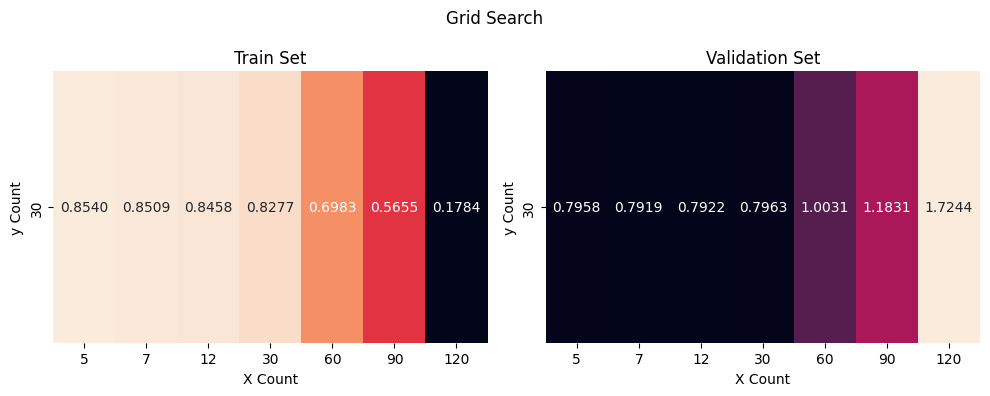

In [236]:
fig, ax = plt.subplots(1,2, figsize=(10, 4))
fig.suptitle("Grid Search")
sns.heatmap(np.transpose(rmse_train), xticklabels=X_params, yticklabels=y_params, annot=True, fmt=".4f", cbar=False, ax=ax[0])
ax[0].set_title("Train Set")
ax[0].set_xlabel("X Count")
ax[0].set_ylabel("y Count")
sns.heatmap(np.transpose(rmse_val), xticklabels=X_params, yticklabels=y_params, annot=True, fmt=".4f", cbar=False, ax=ax[1])
ax[1].set_title("Validation Set")
ax[1].set_xlabel("X Count")
ax[1].set_ylabel("y Count")
fig.tight_layout()

Inference:  
We can see that the is a huge overfitting issue in the 60, 90, and 120. To predict the next 30 day, possible X count are 5, 7, 12, and 30. However, we choose 30 because the margin between train result and validation result is the less.

---
## Model Building

In [237]:
Xy = StaticData(timestamp, data)
Xy.fit(30, 30).transform(True)
Xy.summary()

Summary
Timestamp Shape: (345,)
Data Shape: (345,)
X y Combination
X Shape: (286, 30)
y Shape: (286, 30)
No. Set: 286
Preprocessing
Layer 1: PowerTransformer()


In [238]:
#Xy set without train val split
X = Xy.X
y = Xy.y

In [239]:
#Xy set with train val split
X_train, X_val, y_train, y_val = Xy.split(.7)
X_train.shape, X_val.shape, y_train.shape, y_val.shape

((200, 30), (86, 30), (200, 30), (86, 30))

In [240]:
#Use for Weighted RootMeanSquaredError calculation
sample_weight = Xy.sample_weight
sample_weight

array([0.06451613, 0.06236559, 0.06021505, 0.05806452, 0.05591398,
       0.05376344, 0.0516129 , 0.04946237, 0.04731183, 0.04516129,
       0.04301075, 0.04086022, 0.03870968, 0.03655914, 0.0344086 ,
       0.03225806, 0.03010753, 0.02795699, 0.02580645, 0.02365591,
       0.02150538, 0.01935484, 0.0172043 , 0.01505376, 0.01290323,
       0.01075269, 0.00860215, 0.00645161, 0.00430108, 0.00215054])

In [241]:
class ModelPerformance:
    
    properties = ["Mean", "Std", "Min", "Max"]
    
    def __init__(self):
        self.model = np.empty((0, ), dtype=str)
        self.result = np.empty((0, 4), dtype=np.float32)
        
    def append(self, label_, mean_, std_, min_, max_):
        if label_ in self.model:
            self.result[np.where(self.model==label_)[0]] = [mean_, std_, min_, max_]
        else:
            self.model = np.hstack((self.model, label_))
            self.result = np.vstack((self.result, np.array([mean_, std_, min_, max_])))
        
    def display(self):
        plt.figure(figsize=(10, 4))
        plt.title("Model Performance")
        sns.heatmap(self.result, xticklabels=self.properties, yticklabels=self.model, annot=True, fmt=".4f", cbar=False)
        plt.tight_layout()
        plt.show()
        
model_performance = ModelPerformance()

## Baseline Model

### Naive Forecast Model

In [242]:
class naive_forecast:
    def __init__(self):
        self.value = 0
    
    def fit(self, X):
        self.value = X[-1]
        return self
    
    def predict(self, y):
        return np.full((y.shape[0]), self.value)

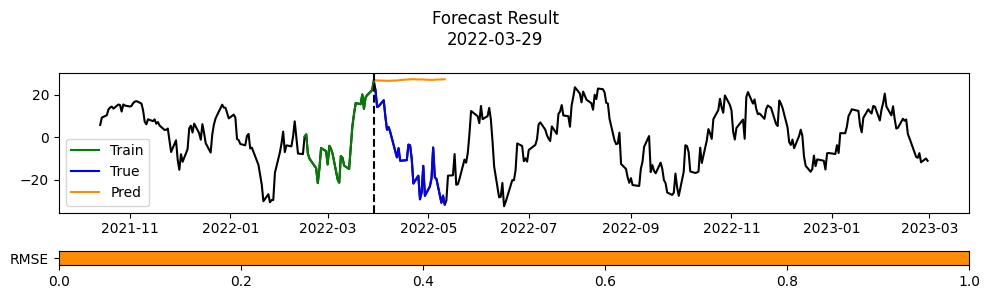

In [243]:
i=85
model = naive_forecast().fit(Xy.X[i])
y_pred = model.predict(Xy.y[i])
Xy.display_forecast(i, y_pred)

In [244]:
rolling_rmse = np.array([])
for i in range(Xy.nset):
    model = naive_forecast().fit(Xy.X[i])
    y_pred = model.predict(Xy.y[i])
    rmse = round(mean_squared_error(Xy.y[i], y_pred, squared=False, sample_weight=sample_weight), 4)
    rolling_rmse = np.append(rolling_rmse, rmse)
rolling_rmse.shape

(286,)

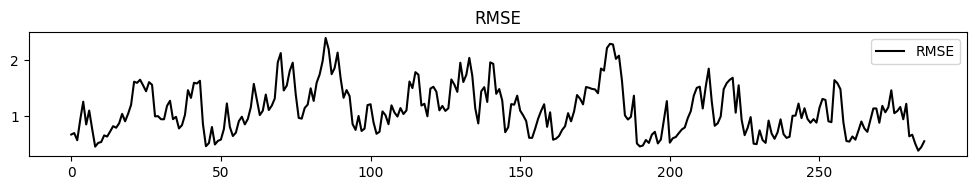

Index (Min Error): 283
Index (Max Error): 85

Mean: 1.1226
Std: 0.4242
Min: 0.3896
Max: 2.395


In [245]:
rmse_mean = round(rolling_rmse.mean(), 4)
rmse_std = round(rolling_rmse.std(), 4)
rmse_min = round(rolling_rmse.min(), 4)
rmse_max = round(rolling_rmse.max(), 4)

label = "Naive Forecast Model"
model_performance.append(label, rmse_mean, rmse_std, rmse_min, rmse_max)

plt.figure(figsize=(10,2))
plt.title("RMSE")
plt.plot(rolling_rmse, color='black')
plt.legend(['RMSE'])
plt.tight_layout()
plt.show()

print("Index (Min Error): {0}".format(rolling_rmse.argmin()))
print("Index (Max Error): {0}".format(rolling_rmse.argmax()))
print("")
print("Mean: {0}".format(rmse_mean))
print("Std: {0}".format(rmse_std))
print("Min: {0}".format(rmse_min))
print("Max: {0}".format(rmse_max))

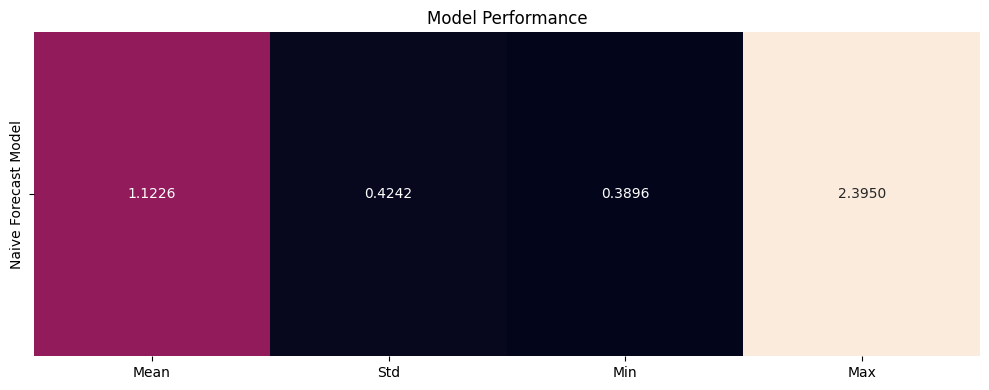

In [246]:
model_performance.display()

## Linear Regression Approach

In [247]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.linear_model import LinearRegression

In [248]:
model = MultiOutputRegressor(LinearRegression()).fit(X_train, y_train)

In [249]:
pred_train = model.predict(X_train)
pred_val = model.predict(X_val)
pred_train.shape, pred_val.shape

((200, 30), (86, 30))

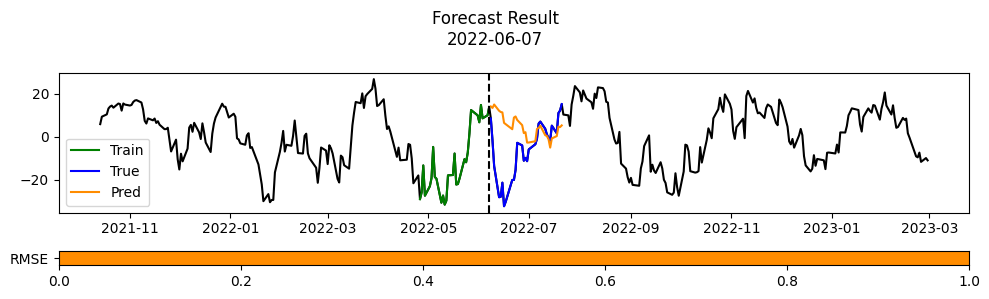

In [250]:
i=133
Xy.display_forecast(i, pred_train[i])

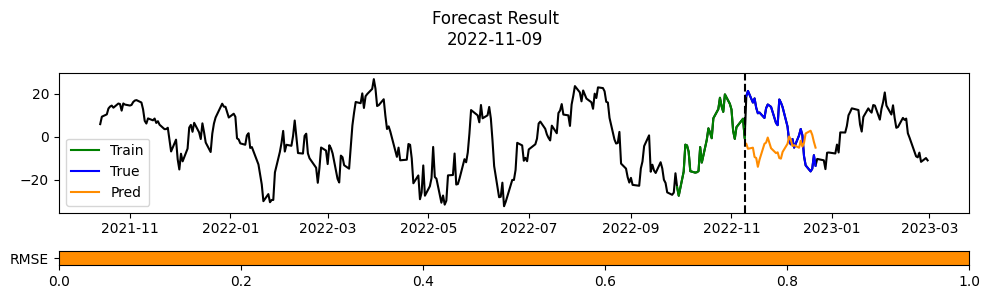

In [251]:
i=41
Xy.display_forecast(i+Xy.X_train.shape[0], pred_val[i])

In [252]:
rolling_train_rmse = np.array([])
rolling_val_rmse = np.array([])

for i, val in enumerate(pred_train):
    rmse = round(mean_squared_error(y_train[i], val, squared=False, sample_weight=sample_weight), 4)
    rolling_train_rmse = np.append(rolling_train_rmse, rmse)
for i, val in enumerate(pred_val):
    rmse = round(mean_squared_error(y_val[i], val, squared=False, sample_weight=sample_weight), 4)
    rolling_val_rmse = np.append(rolling_val_rmse, rmse)

rolling_train_rmse.shape, rolling_val_rmse.shape

((200,), (86,))

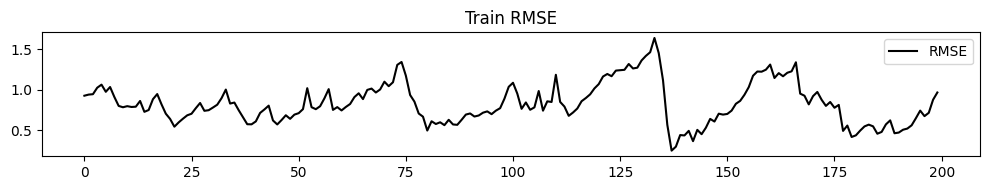

Index (Min Error): 137
Index (Max Error): 133


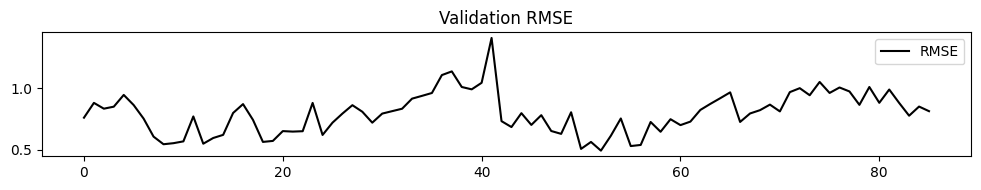

Index (Min Error): 52
Index (Max Error): 41

Mean: 0.7963
Std: 0.1667
Min: 0.4911
Max: 1.4126


In [253]:
rmse_mean = round(rolling_val_rmse.mean(), 4)
rmse_std = round(rolling_val_rmse.std(), 4)
rmse_min = round(rolling_val_rmse.min(), 4)
rmse_max = round(rolling_val_rmse.max(), 4)

label = "LinearRegression Model"
model_performance.append(label, rmse_mean, rmse_std, rmse_min, rmse_max)

rmse_trian_mean = round(rolling_train_rmse.mean(), 4)
rmse_val_mean = round(rolling_val_rmse.mean(), 4)

plt.figure(figsize=(10,2))
plt.title("Train RMSE")
plt.plot(rolling_train_rmse, color='black')
plt.legend(['RMSE'])
plt.tight_layout()
plt.show()
print("Index (Min Error): {0}".format(rolling_train_rmse.argmin()))
print("Index (Max Error): {0}".format(rolling_train_rmse.argmax()))

plt.figure(figsize=(10,2))
plt.title("Validation RMSE")
plt.plot(rolling_val_rmse, color='black')
plt.legend(['RMSE'])
plt.tight_layout()
plt.show()
print("Index (Min Error): {0}".format(rolling_val_rmse.argmin()))
print("Index (Max Error): {0}".format(rolling_val_rmse.argmax()))
print("")
print("Mean: {0}".format(rmse_mean))
print("Std: {0}".format(rmse_std))
print("Min: {0}".format(rmse_min))
print("Max: {0}".format(rmse_max))

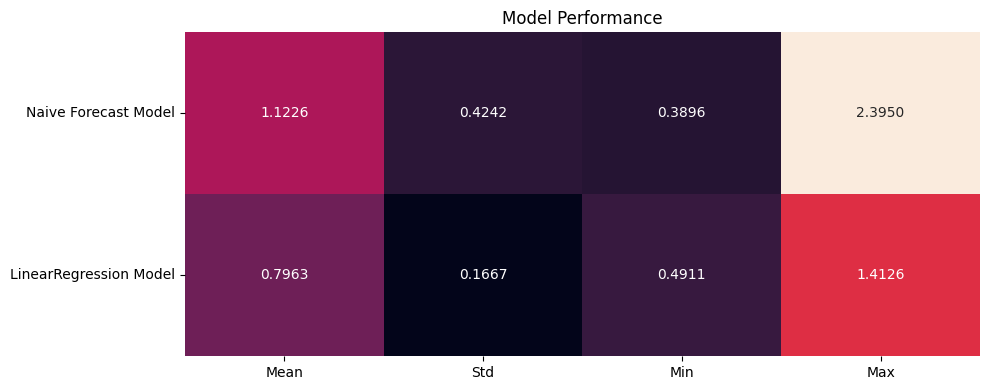

In [254]:
model_performance.display()

## Statictical Approach

In [255]:
from statsmodels.graphics.tsaplots import plot_pacf

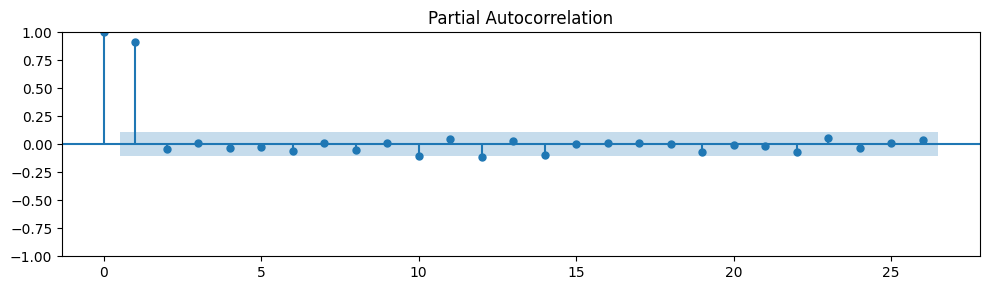

In [256]:
fig, ax = plt.subplots(figsize=(10, 3))
plot_pacf(data, method='ywm', ax=ax)
fig.tight_layout()

### AutoRegressive Model

In [257]:
from statsmodels.tsa.ar_model import AutoReg

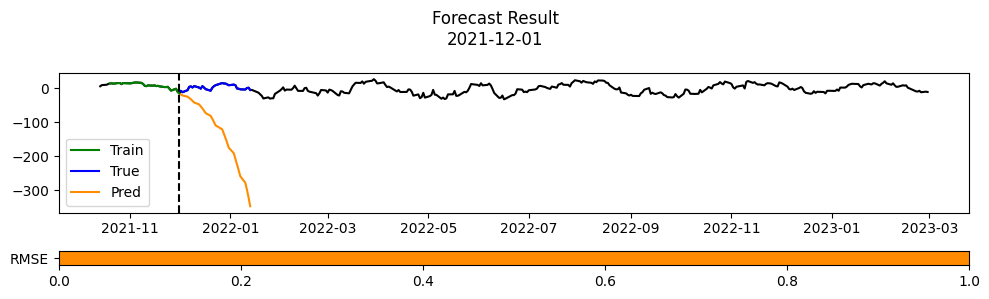

In [258]:
i=4
lags=1
model = AutoReg(X[i], lags=lags).fit()
y_pred = model.predict(start=X[i].shape[0], end=X[i].shape[0]+y[i].shape[0]-1, dynamic=False)
Xy.display_forecast(i, y_pred)

In [259]:
rolling_rmse = np.array([])

for i in range(Xy.nset):
    model = AutoReg(X[i], lags=lags).fit()
    y_pred = model.predict(start=X[i].shape[0], end=X[i].shape[0]+y[i].shape[0]-1, dynamic=False)
    rmse = round(mean_squared_error(y[i], y_pred, squared=False, sample_weight=sample_weight), 4)
    rolling_rmse = np.append(rolling_rmse, rmse)

rolling_rmse.shape

(286,)

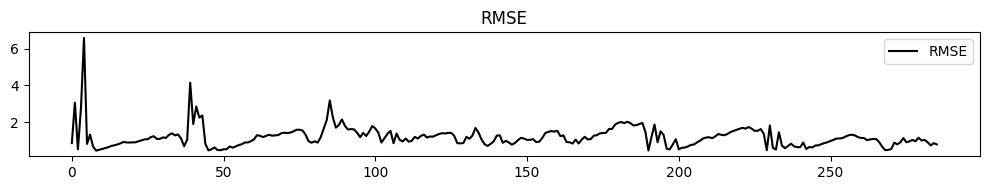

Index (Min Error): 8
Index (Max Error): 4

Mean: 1.1964
Std: 0.5735
Min: 0.4571
Max: 6.5827


In [260]:
rmse_mean = round(rolling_rmse.mean(), 4)
rmse_std = round(rolling_rmse.std(), 4)
rmse_min = round(rolling_rmse.min(), 4)
rmse_max = round(rolling_rmse.max(), 4)

label = "AutoRegression Model"
model_performance.append(label, rmse_mean, rmse_std, rmse_min, rmse_max)

plt.figure(figsize=(10,2))
plt.title("RMSE")
plt.plot(rolling_rmse, color='black')
plt.legend(['RMSE'])
plt.tight_layout()
plt.show()

print("Index (Min Error): {0}".format(rolling_rmse.argmin()))
print("Index (Max Error): {0}".format(rolling_rmse.argmax()))
print("")
print("Mean: {0}".format(rmse_mean))
print("Std: {0}".format(rmse_std))
print("Min: {0}".format(rmse_min))
print("Max: {0}".format(rmse_max))

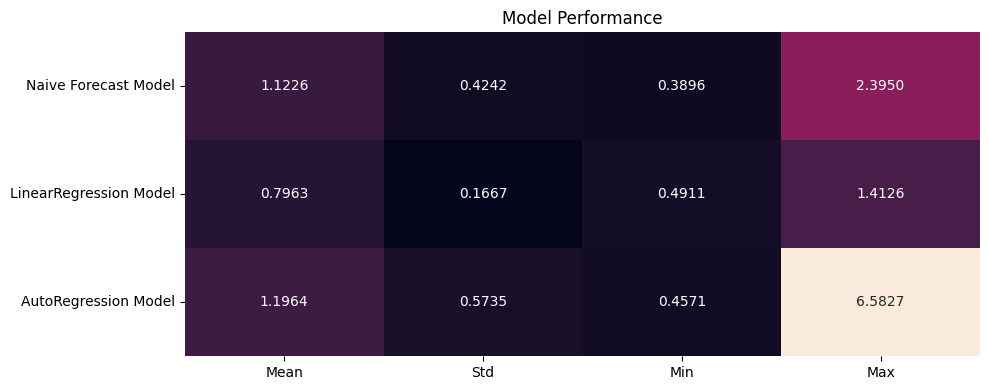

In [261]:
model_performance.display()

## Artificial Neural Network Approach

In [262]:
# Neural Network Model
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import *
from tensorflow.keras.losses import MeanSquaredError
from tensorflow.keras.metrics import RootMeanSquaredError
from tensorflow.keras.optimizers import Adam
from tensorflow.keras.callbacks import ModelCheckpoint
from tensorflow.keras.models import load_model

### LSTM Model

In [280]:
model = Sequential()
model.add(Input((X_train.shape[1], 1)))
model.add(LSTM(128))
model.add(Dense(64, activation='relu'))
model.add(Dense(y_train.shape[1]))
model.summary()

Model: "sequential_5"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 lstm_5 (LSTM)               (None, 128)               66560     
                                                                 
 dense_10 (Dense)            (None, 64)                8256      
                                                                 
 dense_11 (Dense)            (None, 30)                1950      
                                                                 
Total params: 76,766
Trainable params: 76,766
Non-trainable params: 0
_________________________________________________________________


In [282]:
cp = ModelCheckpoint('model/', save_best_only=True)

model.compile(loss=MeanSquaredError(),
                optimizer=Adam(learning_rate=0.001),
                loss_weights=sample_weight,
                weighted_metrics=[RootMeanSquaredError()])

model.fit(X_train, y_train, validation_data=(X_val, y_val), epochs=10, callbacks=[cp])

Epoch 1/10
6/7 [========================>.....] - ETA: 0s - loss: 0.0231 - root_mean_squared_error: 0.8333

INFO:tensorflow:Assets written to: model\assets


INFO:tensorflow:Assets written to: model\assets


7/7 [==============================] - 4s 437ms/step - loss: 0.0229 - root_mean_squared_error: 0.8283 - val_loss: 0.0269 - val_root_mean_squared_error: 0.8979
Epoch 2/10
7/7 [==============================] - 0s 18ms/step - loss: 0.0209 - root_mean_squared_error: 0.7917 - val_loss: 0.0292 - val_root_mean_squared_error: 0.9362
Epoch 3/10
7/7 [==============================] - 0s 18ms/step - loss: 0.0192 - root_mean_squared_error: 0.7580 - val_loss: 0.0324 - val_root_mean_squared_error: 0.9859
Epoch 4/10
7/7 [==============================] - 0s 18ms/step - loss: 0.0174 - root_mean_squared_error: 0.7219 - val_loss: 0.0340 - val_root_mean_squared_error: 1.0105
Epoch 5/10
7/7 [==============================] - 0s 20ms/step - loss: 0.0157 - root_mean_squared_error: 0.6861 - val_loss: 0.0364 - val_root_mean_squared_error: 1.0446
Epoch 6/10
7/7 [==============================] - 0s 18ms/step - loss: 0.0146 - root_mean_squared_error: 0.6614 - val_loss: 0.0383 - val_root_mean_squared_error: 1.0

In [283]:
model = load_model('model/')
pred_train = model.predict(X_train)
pred_val = model.predict(X_val)
pred_train.shape, pred_val.shape

3/3 [==============================] - 0s 4ms/step


((200, 30), (86, 30))

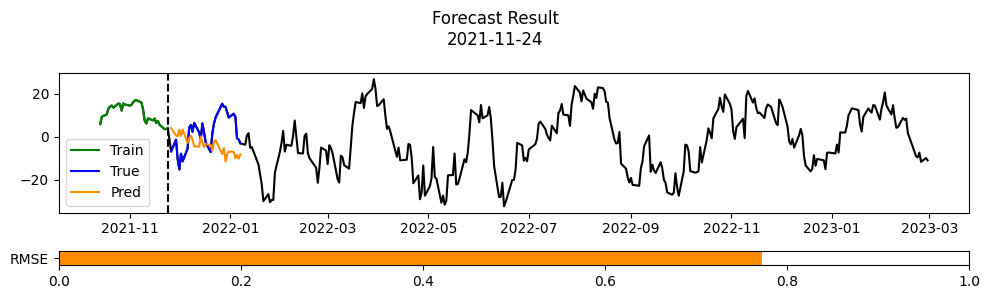

In [284]:
i=0
Xy.display_forecast(i, pred_train[i])

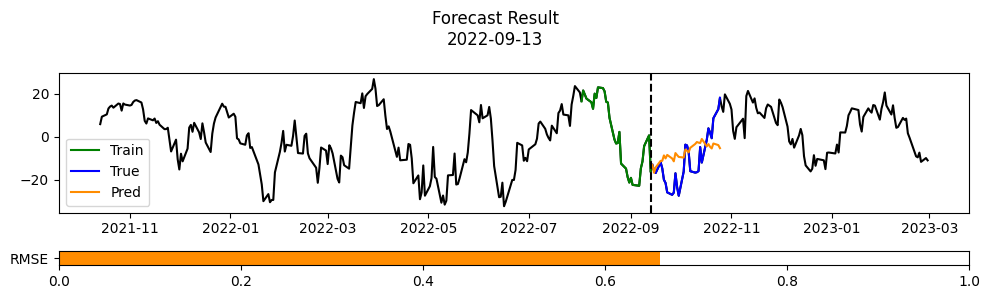

In [285]:
i=0
Xy.display_forecast(i+Xy.X_train.shape[0], pred_val[i])

In [268]:
rolling_train_rmse = np.array([])
rolling_val_rmse = np.array([])

for i, val in enumerate(pred_train):
    rmse = round(mean_squared_error(y_train[i], val, squared=False, sample_weight=sample_weight), 4)
    rolling_train_rmse = np.append(rolling_train_rmse, rmse)
for i, val in enumerate(pred_val):
    rmse = round(mean_squared_error(y_val[i], val, squared=False, sample_weight=sample_weight), 4)
    rolling_val_rmse = np.append(rolling_val_rmse, rmse)

rolling_train_rmse.shape, rolling_val_rmse.shape

((200,), (86,))

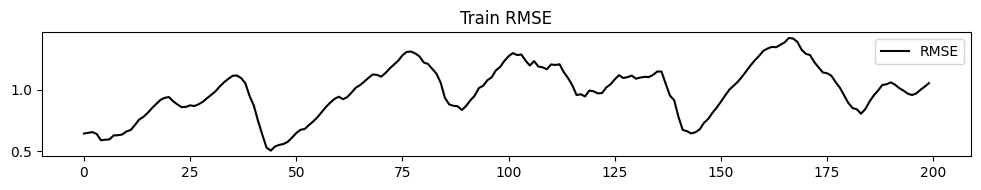

Index (Min Error): 44
Index (Max Error): 166


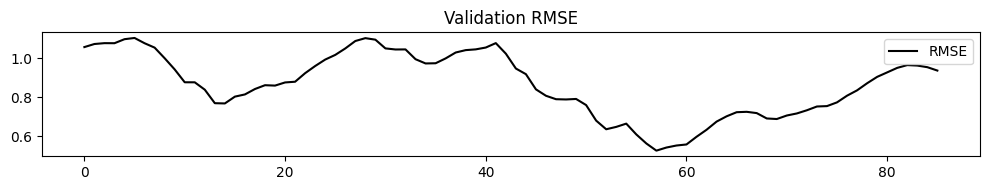

Index (Min Error): 57
Index (Max Error): 5

Mean: 0.8674
Std: 0.1626
Min: 0.5254
Max: 1.1055


In [269]:
rmse_mean = round(rolling_val_rmse.mean(), 4)
rmse_std = round(rolling_val_rmse.std(), 4)
rmse_min = round(rolling_val_rmse.min(), 4)
rmse_max = round(rolling_val_rmse.max(), 4)

label = "LSTM Model"
model_performance.append(label, rmse_mean, rmse_std, rmse_min, rmse_max)

rmse_trian_mean = round(rolling_train_rmse.mean(), 4)
rmse_val_mean = round(rolling_val_rmse.mean(), 4)

plt.figure(figsize=(10,2))
plt.title("Train RMSE")
plt.plot(rolling_train_rmse, color='black')
plt.legend(['RMSE'])
plt.tight_layout()
plt.show()
print("Index (Min Error): {0}".format(rolling_train_rmse.argmin()))
print("Index (Max Error): {0}".format(rolling_train_rmse.argmax()))

plt.figure(figsize=(10,2))
plt.title("Validation RMSE")
plt.plot(rolling_val_rmse, color='black')
plt.legend(['RMSE'])
plt.tight_layout()
plt.show()
print("Index (Min Error): {0}".format(rolling_val_rmse.argmin()))
print("Index (Max Error): {0}".format(rolling_val_rmse.argmax()))
print("")
print("Mean: {0}".format(rmse_mean))
print("Std: {0}".format(rmse_std))
print("Min: {0}".format(rmse_min))
print("Max: {0}".format(rmse_max))

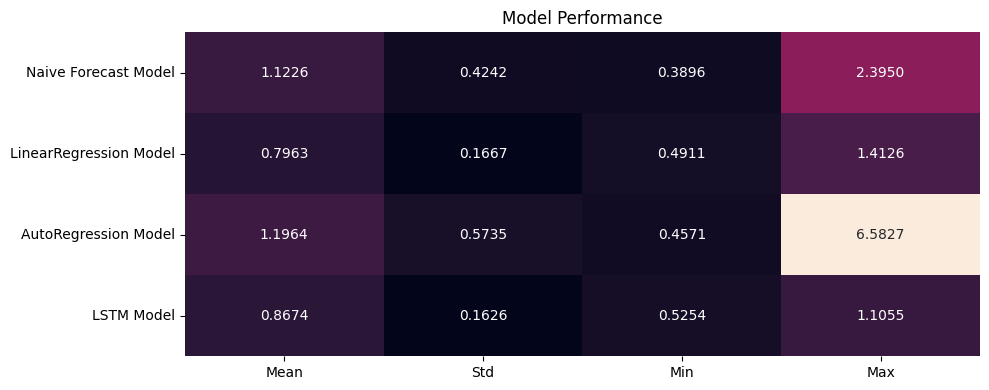

In [270]:
model_performance.display()

## SVM Approach

In [271]:
from sklearn.multioutput import MultiOutputRegressor
from sklearn.svm import SVR

In [272]:
model = MultiOutputRegressor(SVR(kernel="poly", C=500, gamma="auto", degree=3, epsilon=0.5, coef0=1)).fit(X_train, y_train)

In [273]:
pred_train = model.predict(X_train)
pred_val = model.predict(X_val)
pred_train.shape, pred_val.shape

((200, 30), (86, 30))

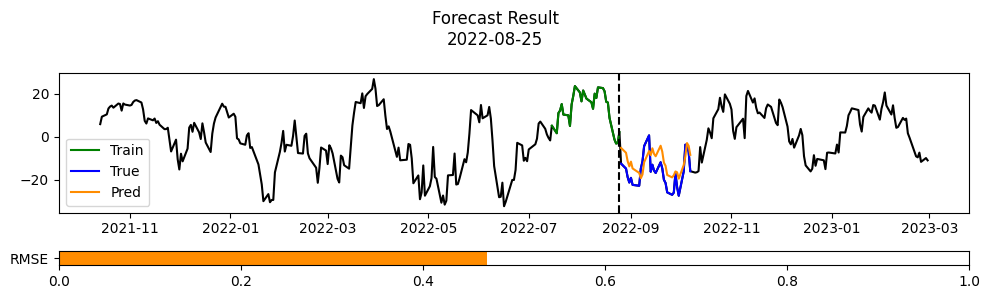

In [274]:
i=188
Xy.display_forecast(i, pred_train[i])

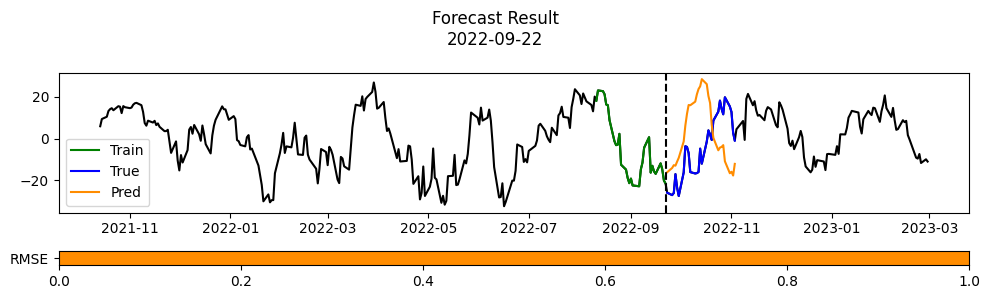

In [275]:
i=7
Xy.display_forecast(i+Xy.X_train.shape[0], pred_val[i])

In [276]:
rolling_train_rmse = np.array([])
rolling_val_rmse = np.array([])

for i, val in enumerate(pred_train):
    rmse = round(mean_squared_error(y_train[i], val, squared=False, sample_weight=sample_weight), 4)
    rolling_train_rmse = np.append(rolling_train_rmse, rmse)
for i, val in enumerate(pred_val):
    rmse = round(mean_squared_error(y_val[i], val, squared=False, sample_weight=sample_weight), 4)
    rolling_val_rmse = np.append(rolling_val_rmse, rmse)

rolling_train_rmse.shape, rolling_val_rmse.shape

((200,), (86,))

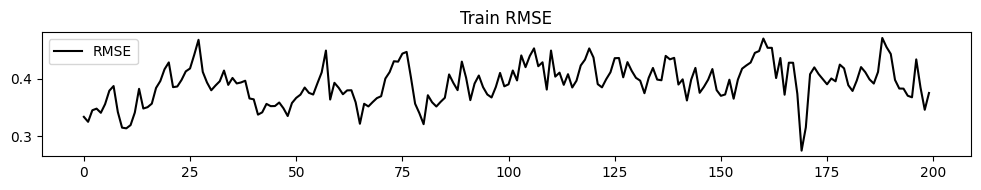

Index (Min Error): 169
Index (Max Error): 188


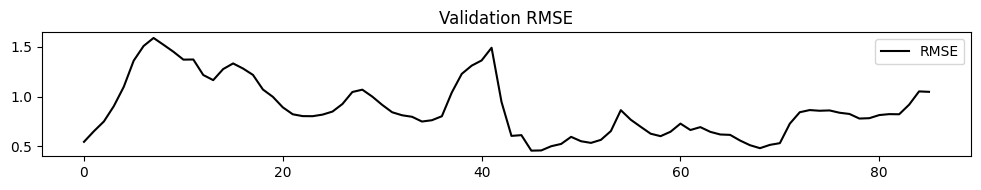

Index (Min Error): 45
Index (Max Error): 7

Mean: 0.8771
Std: 0.2877
Min: 0.4559
Max: 1.5896


In [277]:
rmse_mean = round(rolling_val_rmse.mean(), 4)
rmse_std = round(rolling_val_rmse.std(), 4)
rmse_min = round(rolling_val_rmse.min(), 4)
rmse_max = round(rolling_val_rmse.max(), 4)

label = "SVR Model"
model_performance.append(label, rmse_mean, rmse_std, rmse_min, rmse_max)

rmse_trian_mean = round(rolling_train_rmse.mean(), 4)
rmse_val_mean = round(rolling_val_rmse.mean(), 4)

plt.figure(figsize=(10,2))
plt.title("Train RMSE")
plt.plot(rolling_train_rmse, color='black')
plt.legend(['RMSE'])
plt.tight_layout()
plt.show()
print("Index (Min Error): {0}".format(rolling_train_rmse.argmin()))
print("Index (Max Error): {0}".format(rolling_train_rmse.argmax()))

plt.figure(figsize=(10,2))
plt.title("Validation RMSE")
plt.plot(rolling_val_rmse, color='black')
plt.legend(['RMSE'])
plt.tight_layout()
plt.show()
print("Index (Min Error): {0}".format(rolling_val_rmse.argmin()))
print("Index (Max Error): {0}".format(rolling_val_rmse.argmax()))
print("")
print("Mean: {0}".format(rmse_mean))
print("Std: {0}".format(rmse_std))
print("Min: {0}".format(rmse_min))
print("Max: {0}".format(rmse_max))

---
## Model Performance

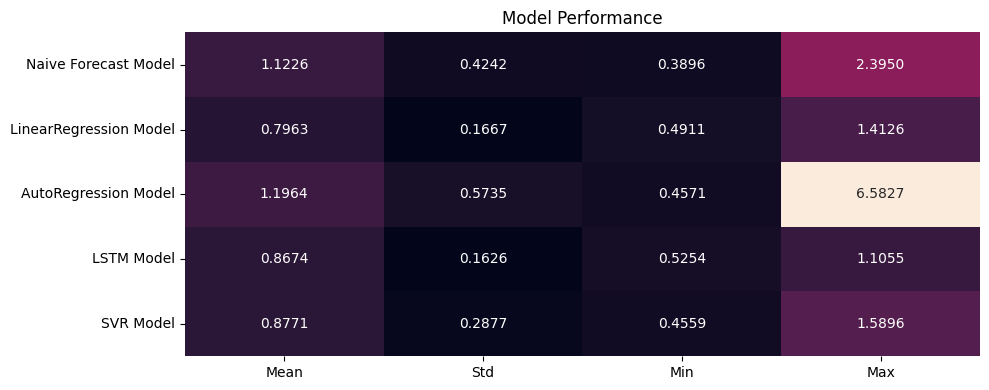

Significant Level: 0.7858


In [278]:
model_performance.display()
print("Significant Level: {0}".format(round(model_performance.result[0, 0]*.7, 4)))

## Conclusion: Hypothesis Rejected